In [1]:
# Basics
from glob import glob # finds pathnames
import os # Miscellaneous operating system interfaces
import sys
import random
import timeit
import imp
import gc

# Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.ndimage import label as scipy_label
from scipy.ndimage import generate_binary_structure

# Image manipulation
import skimage

# Import Mask RCNN
sys.path.append('mrcnn')  # To find local version of the library
from config import Config
# Imp import to ensure loading the correct utils package
fp, pathname, description = imp.find_module('utils',['mrcnn'])
utils = imp.load_module('utils',fp,pathname,description)
import model as modellib
import visualize
from model import log

# Plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Paths
ROOT_DIR = 'C:/Users/HPDQ/Mask_RCNN/DATASET/severstal'
Train_Dir = os.path.join(ROOT_DIR, 'train_images/')
Test_Dir = os.path.join(ROOT_DIR, 'test_images/')

# Directory to save logs and trained model
MODEL_DIR = 'logs'

# Local path to trained weights file
# Trained_Weights = '../input/????.h5'

In [3]:
print (Train_Dir)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images/


In [4]:
class SteelConfig(Config):
    """Configuration for training on the steel dataset.
    Derives from the base Config class and overrides values specific
    to the steel dataset.
    """
    # Give the configuration a recognizable name
    NAME = "steel"

    # Train on 1 GPU and 1 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 defect classes

    # Use small images (128x128) for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our objects tend to be small 
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images have few objects.
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # Number of epochs
    EPOCHS = 20
    
    # Steps per epoch
    STEPS_PER_EPOCH = 100

    # validation steps per epoch
    VALIDATION_STEPS = 5
    
    # Non-maximum suppression threshold for detection, default 0.3
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Non-max suppression threshold to filter RPN proposals. default 0.7
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         20
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE     

In [5]:
class SteelDataset(utils.Dataset):

    def load_steel(self, dataset_dir, files):
        """Load a subset of the Steel dataset.
        
        Input:
        dataset_dir: Root directory of the dataset.
        files: filenames of images to load
        
        Creates:
        image objects:
            source: source label
            image_id: id, used filename
            path: path + filename
            rle: rle mask encoded pixels, required for mask conversion
            classes: classes for the rle masks, required for mask conversion        
        """
        # Add classes.
        self.add_class("steel", 1, "defect1")
        self.add_class("steel", 2, "defect2")
        self.add_class("steel", 3, "defect3")
        self.add_class("steel", 4, "defect4")
        
        # Load annotations CSV
        annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

        # Remove images without Encoding
        annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
        
        # Split ImageId_ClassId
        #ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
        #annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
        #annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]     

        for file in files:
            EncodedPixels = [annotations_train_Encoded['EncodedPixels'][annotations_train_Encoded['ImageId'] == file]]
            ClassID = (annotations_train_Encoded['ClassId'][annotations_train_Encoded['ImageId'] == file])

            self.add_image(
                source = "steel",
                image_id = file,  # use filename as a unique image id
                path = Train_Dir + '/' + file,
                rle = EncodedPixels,
                classes = ClassID)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Input:
        image_id: id of the image
        
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D int array of class IDs of the instance masks.
        """
        # If not a steel dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "steel":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert rle to single mask
        ClassIDIndex = 0
        ClassID = np.empty(0, dtype = int)
        maskarray = np.empty((256, 1600, 0), dtype = int)
        for rlelist in image_info['rle']:
            for row in rlelist:
                mask= np.zeros(1600 * 256 ,dtype=np.uint8)
                array = np.asarray([int(x) for x in row.split()])
                starts = array[0::2]-1
                lengths = array[1::2]    
                for index, start in enumerate(starts):
                    mask[int(start):int(start+lengths[index])] = 1
                mask = mask.reshape((256,1600), order='F')
                # Label mask elements
                structure = generate_binary_structure(2,2)
                labeled_array, labels = scipy_label(mask, structure)
                # Convert labeled_array elements to bitmap mask array
                for label in range(labels):
                    labelmask = np.copy(labeled_array)    
                    labelmask[labelmask != label + 1] = 0
                    if label == 0:
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    else:
                        labelmask[labelmask == label + 1] = 1
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    # Update ClassID list
                    ClassID = np.append(ClassID,int(image_info['classes'].iloc[ClassIDIndex]))
                ClassIDIndex = ClassIDIndex + 1

        # Return mask, and array of class IDs of each instance.
        return maskarray.astype(np.bool), ClassID

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "steel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal
image_id  0 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//000a4bcdd.jpg
image                    shape: (256, 1600, 3)        min:   24.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 10)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (10,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (10, 4)               min:   55.00000  max:  462.00000  int32


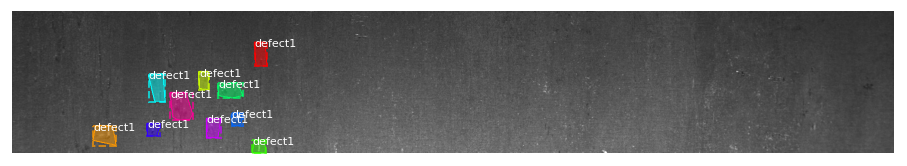

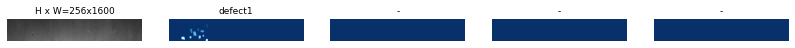

image_id  1 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//000f6bf48.jpg
image                    shape: (256, 1600, 3)        min:   16.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 2)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    4.00000  max:    4.00000  int32
bbox                     shape: (2, 4)                min:    0.00000  max: 1132.00000  int32


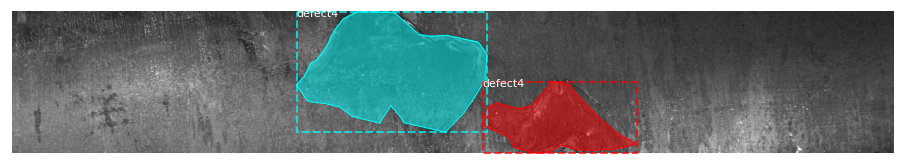

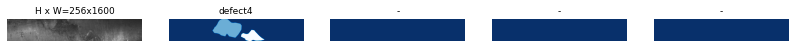

image_id  2 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00ac8372f.jpg
image                    shape: (256, 1600, 3)        min:    1.00000  max:  253.00000  uint8
mask                     shape: (256, 1600, 3)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (3, 4)                min:    0.00000  max:  451.00000  int32


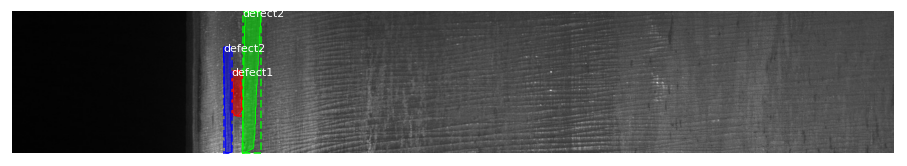

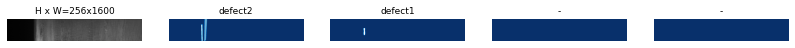

image_id  3 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00af2671f.jpg
image                    shape: (256, 1600, 3)        min:   26.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 5)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (5, 4)                min:    0.00000  max: 1121.00000  int32


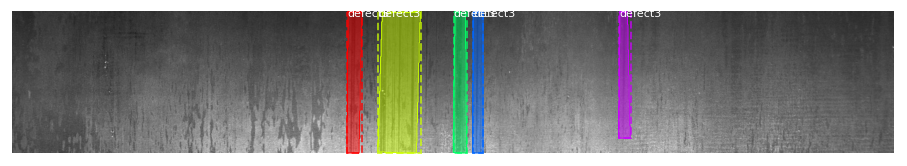

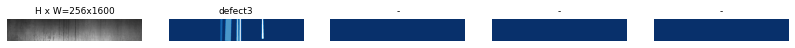

In [6]:
# Load example images and masks.
files = ['000a4bcdd.jpg', '000f6bf48.jpg', '00ac8372f.jpg', '00af2671f.jpg']
dataset = SteelDataset()
print(ROOT_DIR)
dataset.load_steel(ROOT_DIR, files)
dataset.prepare()

image_ids = [0,1,2,3] 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [7]:
# select files for test and validation dataset
# Load annotations CSV
annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

# Remove images without Encoding
annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        

# Split ImageId_ClassId
#ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
#annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
#annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]

# Split dataframe
msk = np.random.rand(len(annotations_train_Encoded)) < 0.85
train_msk = annotations_train_Encoded[msk]
val_msk = annotations_train_Encoded[~msk]
train = train_msk['ImageId'].unique().copy()
val = val_msk['ImageId'].unique().copy()
print('Train images: ' + str(len(train)))
print('Test images: ' + str(len(val)))
# Cleanup
del annotations_train, annotations_train_Encoded, msk, train_msk, val_msk 
gc.collect()

Train images: 5703
Test images: 1077


55913

In [8]:
# Training preperations
# Training dataset
dataset_train = SteelDataset()
dataset_train.load_steel(ROOT_DIR, train)
dataset_train.prepare()

# Validation dataset
dataset_val = SteelDataset()
dataset_val.load_steel(ROOT_DIR, val)
dataset_val.prepare()

# Build training model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []
# Load weights to continue training
# model.load_weights(Trained_Weights, by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Train model
timestart = timeit.default_timer()
print("Training")
model.train(dataset_train, 
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=config.EPOCHS,
            layers='all')
print ('Total run time: ' + str(runtime) + ' minutes')

Training

Starting at epoch 0. LR=0.001

Checkpoint Path: logs\steel20211009T2008\mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "












Epoch 1/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:28:26 - loss: 32.8241 - rpn_class_loss: 15.2526 - rpn_bbox_loss: 6.1059 - mrcnn_class_loss: 11.4655 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:15:11 - loss: 27.9208 - rpn_class_loss: 13.7572 - rpn_bbox_loss: 6.3121 - mrcnn_class_loss: 7.8515 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:10:17 - loss: 21.8979 - rpn_class_loss: 11.1603 - rpn_bbox_loss: 5.5026 - mrcnn_class_loss: 5.2349 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:07:07 - loss: 19.0875 - rpn_class_loss: 9.2558 - rpn_bbox_loss: 5.9054 - mrcnn_class_loss: 3.9262 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:05:05 - loss: 18.6204 - rpn_class_loss: 8.0148 - rpn_bbox_loss: 7.4647 - mrcnn_class_loss: 3.1410 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:03:41 - loss: 16.3292 - rpn_class_loss: 7.0049 - rpn_bbox_loss: 6.7067 - mrcnn_class_loss: 2.6175 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:02:30 - loss: 15.2324 - rpn_class_loss: 6.1769 - rpn_bbox_loss: 6.8119 - mrcnn_class_loss: 2.2435 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:01:25 - loss: 14.8506 - rpn_class_loss: 5.5183 - rpn_bbox_loss: 7.3691 - mrcnn_class_loss: 1.9631 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:35 - loss: 13.5016 - rpn_class_loss: 4.9764 - rpn_bbox_loss: 6.7801 - mrcnn_class_loss: 1.7450 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:34 - loss: 12.6857 - rpn_class_loss: 4.5249 - rpn_bbox_loss: 6.5902 - mrcnn_class_loss: 1.5705 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:42 - loss: 11.8729 - rpn_class_loss: 4.1307 - rpn_bbox_loss: 6.3145 - mrcnn_class_loss: 1.4277 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:50 - loss: 11.2584 - rpn_class_loss: 3.8102 - rpn_bbox_loss: 6.1395 - mrcnn_class_loss: 1.3087 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:05 - loss: 10.7170 - rpn_class_loss: 3.5292 - rpn_bbox_loss: 5.9796 - mrcnn_class_loss: 1.2081 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:19 - loss: 10.1078 - rpn_class_loss: 3.2853 - rpn_bbox_loss: 5.7007 - mrcnn_class_loss: 1.1218 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:35 - loss: 9.5678 - rpn_class_loss: 3.0860 - rpn_bbox_loss: 5.4349 - mrcnn_class_loss: 1.0470 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:51 - loss: 9.1698 - rpn_class_loss: 2.9015 - rpn_bbox_loss: 5.2867 - mrcnn_class_loss: 0.9816 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:08 - loss: 9.0099 - rpn_class_loss: 2.7445 - rpn_bbox_loss: 5.3416 - mrcnn_class_loss: 0.9238 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:24 - loss: 8.7486 - rpn_class_loss: 2.6048 - rpn_bbox_loss: 5.2713 - mrcnn_class_loss: 0.8725 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:39 - loss: 8.6262 - rpn_class_loss: 2.4697 - rpn_bbox_loss: 5.3299 - mrcnn_class_loss: 0.8266 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 51:58 - loss: 8.3245 - rpn_class_loss: 2.3533 - rpn_bbox_loss: 5.1859 - mrcnn_class_loss: 0.7852 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:18 - loss: 8.2365 - rpn_class_loss: 2.2666 - rpn_bbox_loss: 5.2220 - mrcnn_class_loss: 0.7478 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:38 - loss: 8.0892 - rpn_class_loss: 2.1686 - rpn_bbox_loss: 5.2068 - mrcnn_class_loss: 0.7139 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 49:59 - loss: 7.8689 - rpn_class_loss: 2.0979 - rpn_bbox_loss: 5.0882 - mrcnn_class_loss: 0.6828 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:19 - loss: 7.7099 - rpn_class_loss: 2.0131 - rpn_bbox_loss: 5.0424 - mrcnn_class_loss: 0.6544 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 48:41 - loss: 7.6079 - rpn_class_loss: 1.9356 - rpn_bbox_loss: 5.0442 - mrcnn_class_loss: 0.6282 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:03 - loss: 7.4283 - rpn_class_loss: 1.8819 - rpn_bbox_loss: 4.9424 - mrcnn_class_loss: 0.6040 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:24 - loss: 7.1935 - rpn_class_loss: 1.8144 - rpn_bbox_loss: 4.7973 - mrcnn_class_loss: 0.5817 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 46:45 - loss: 7.0309 - rpn_class_loss: 1.7632 - rpn_bbox_loss: 4.7069 - mrcnn_class_loss: 0.5609 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:04 - loss: 6.9373 - rpn_class_loss: 1.7046 - rpn_bbox_loss: 4.6911 - mrcnn_class_loss: 0.5415 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:23 - loss: 6.8664 - rpn_class_loss: 1.6496 - rpn_bbox_loss: 4.6932 - mrcnn_class_loss: 0.5235 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 44:43 - loss: 6.7852 - rpn_class_loss: 1.5986 - rpn_bbox_loss: 4.6800 - mrcnn_class_loss: 0.5066 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:02 - loss: 6.6700 - rpn_class_loss: 1.5507 - rpn_bbox_loss: 4.6285 - mrcnn_class_loss: 0.4908 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:22 - loss: 6.6309 - rpn_class_loss: 1.5054 - rpn_bbox_loss: 4.5407 - mrcnn_class_loss: 0.4813 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.0210        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 42:43 - loss: 6.5045 - rpn_class_loss: 1.4697 - rpn_bbox_loss: 4.4672 - mrcnn_class_loss: 0.4671 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.0203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:02 - loss: 6.4321 - rpn_class_loss: 1.4380 - rpn_bbox_loss: 4.4428 - mrcnn_class_loss: 0.4538 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.0198

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:23 - loss: 6.5451 - rpn_class_loss: 1.4042 - rpn_bbox_loss: 4.6049 - mrcnn_class_loss: 0.4412 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.0192

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 40:45 - loss: 6.4247 - rpn_class_loss: 1.3765 - rpn_bbox_loss: 4.5266 - mrcnn_class_loss: 0.4292 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.0187

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:05 - loss: 6.2745 - rpn_class_loss: 1.3419 - rpn_bbox_loss: 4.4248 - mrcnn_class_loss: 0.4179 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.0182

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:26 - loss: 6.1899 - rpn_class_loss: 1.3098 - rpn_bbox_loss: 4.3529 - mrcnn_class_loss: 0.4117 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.0360

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:46 - loss: 6.1571 - rpn_class_loss: 1.2797 - rpn_bbox_loss: 4.3635 - mrcnn_class_loss: 0.4014 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.0351

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:07 - loss: 6.0515 - rpn_class_loss: 1.2497 - rpn_bbox_loss: 4.3004 - mrcnn_class_loss: 0.3916 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.0342

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:27 - loss: 6.0002 - rpn_class_loss: 1.2220 - rpn_bbox_loss: 4.2887 - mrcnn_class_loss: 0.3823 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.0334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:47 - loss: 5.9458 - rpn_class_loss: 1.1960 - rpn_bbox_loss: 4.2297 - mrcnn_class_loss: 0.3781 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.0487

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:08 - loss: 5.8961 - rpn_class_loss: 1.1701 - rpn_bbox_loss: 4.2177 - mrcnn_class_loss: 0.3695 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.0476

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:28 - loss: 5.8013 - rpn_class_loss: 1.1451 - rpn_bbox_loss: 4.1592 - mrcnn_class_loss: 0.3613 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.0465

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:48 - loss: 5.7381 - rpn_class_loss: 1.1227 - rpn_bbox_loss: 4.1291 - mrcnn_class_loss: 0.3535 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.0455

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:10 - loss: 5.6854 - rpn_class_loss: 1.0998 - rpn_bbox_loss: 4.1098 - mrcnn_class_loss: 0.3459 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.0446

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:30 - loss: 5.6877 - rpn_class_loss: 1.0776 - rpn_bbox_loss: 4.1442 - mrcnn_class_loss: 0.3387 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.0436

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:51 - loss: 5.6470 - rpn_class_loss: 1.0573 - rpn_bbox_loss: 4.0886 - mrcnn_class_loss: 0.3339 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.0558

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:12 - loss: 5.5997 - rpn_class_loss: 1.0374 - rpn_bbox_loss: 4.0712 - mrcnn_class_loss: 0.3273 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.0547

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:32 - loss: 5.5351 - rpn_class_loss: 1.0181 - rpn_bbox_loss: 4.0356 - mrcnn_class_loss: 0.3209 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.0536

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:53 - loss: 5.4760 - rpn_class_loss: 0.9999 - rpn_bbox_loss: 4.0039 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.0526

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:14 - loss: 5.4015 - rpn_class_loss: 0.9829 - rpn_bbox_loss: 3.9553 - mrcnn_class_loss: 0.3088 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.0516

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:35 - loss: 5.4199 - rpn_class_loss: 0.9654 - rpn_bbox_loss: 3.9997 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.0507

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:56 - loss: 5.3527 - rpn_class_loss: 0.9503 - rpn_bbox_loss: 3.9559 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.0497

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:17 - loss: 5.2904 - rpn_class_loss: 0.9350 - rpn_bbox_loss: 3.9168 - mrcnn_class_loss: 0.2922 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.0488

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:37 - loss: 5.2424 - rpn_class_loss: 0.9204 - rpn_bbox_loss: 3.8912 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.0480

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:58 - loss: 5.1830 - rpn_class_loss: 0.9056 - rpn_bbox_loss: 3.8539 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.0472

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:19 - loss: 5.1688 - rpn_class_loss: 0.8910 - rpn_bbox_loss: 3.8616 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.0464

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:40 - loss: 5.1673 - rpn_class_loss: 0.8769 - rpn_bbox_loss: 3.8811 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.0456

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:02 - loss: 5.1067 - rpn_class_loss: 0.8635 - rpn_bbox_loss: 3.8406 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.0448

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:23 - loss: 5.0760 - rpn_class_loss: 0.8524 - rpn_bbox_loss: 3.8274 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.0441

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:44 - loss: 5.0366 - rpn_class_loss: 0.8396 - rpn_bbox_loss: 3.8071 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.0434

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:05 - loss: 5.0429 - rpn_class_loss: 0.8289 - rpn_bbox_loss: 3.8302 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.0427

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:26 - loss: 4.9825 - rpn_class_loss: 0.8166 - rpn_bbox_loss: 3.7880 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.0421

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:47 - loss: 4.9929 - rpn_class_loss: 0.8080 - rpn_bbox_loss: 3.7600 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.0534

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:09 - loss: 4.9869 - rpn_class_loss: 0.7970 - rpn_bbox_loss: 3.7188 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.0637

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:31 - loss: 4.9401 - rpn_class_loss: 0.7860 - rpn_bbox_loss: 3.6900 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.0627

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:52 - loss: 4.9275 - rpn_class_loss: 0.7753 - rpn_bbox_loss: 3.6552 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.0722

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:13 - loss: 4.9071 - rpn_class_loss: 0.7649 - rpn_bbox_loss: 3.6213 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.1855 - mrcnn_mask_loss: 0.0819

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.show()